In [26]:
zip_path = "/content/figshare.zip"   # change to your zip name
extract_dir = "/content/brain_tumor_mat"

import zipfile, os

os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

print("Extracted to:", extract_dir)


Extracted to: /content/brain_tumor_mat


In [27]:
!pip install h5py opencv-python-headless

import os, glob
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


In [28]:
!pip install h5py

import h5py, os, glob
import numpy as np

mat_folder = "/content/brain_tumor_mat/dataset/data"   # your folder

sample_mat = sorted(glob.glob(os.path.join(mat_folder, "*.mat")))[0]
print("Sample .mat:", sample_mat)

with h5py.File(sample_mat, "r") as f:
    print("Top-level keys:", list(f.keys()))   # should include 'cjdata'
    cj = f["cjdata"]
    print("cj keys:", list(cj.keys()))         # expect ['PID','image','label','tumorBorder','tumorMask']

    # Just to confirm shapes:
    img  = cj["image"][()]
    mask = cj["tumorMask"][()]
    label = cj["label"][()]
    print("image shape:", img.shape, "mask shape:", mask.shape, "label:", label)


Sample .mat: /content/brain_tumor_mat/dataset/data/1.mat
Top-level keys: ['cjdata']
cj keys: ['PID', 'image', 'label', 'tumorBorder', 'tumorMask']
image shape: (512, 512) mask shape: (512, 512) label: [[1.]]


In [29]:
import os, glob
import numpy as np
import cv2
import h5py

mat_folder = "/content/brain_tumor_mat/dataset/data"   # your .mat folder

out_root   = "/content/figshare"
out_images = os.path.join(out_root, "images")
out_masks  = os.path.join(out_root, "masks")
out_labels = os.path.join(out_root, "labels.txt")

os.makedirs(out_images, exist_ok=True)
os.makedirs(out_masks,  exist_ok=True)

mat_files = sorted(glob.glob(os.path.join(mat_folder, "*.mat")))
print("Found", len(mat_files), "mat files")

label_f = open(out_labels, "w")
idx = 1

for mat_path in mat_files:
    with h5py.File(mat_path, "r") as f:
        cj    = f["cjdata"]
        img   = cj["image"][()]       # (512, 512)
        mask  = cj["tumorMask"][()]   # (512, 512)
        label = cj["label"][()]       # [[1.]] / [[2.]] / [[3.]]

    # convert to uint8
    img  = img.astype("uint8")
    mask = (mask > 0).astype("uint8") * 255   # 0 or 255

    img_name  = f"{idx}.png"
    mask_name = f"{idx}.png"

    cv2.imwrite(os.path.join(out_images, img_name), img)
    cv2.imwrite(os.path.join(out_masks,  mask_name), mask)

    label_int = int(np.array(label).flatten()[0])
    label_f.write(f"{img_name},{label_int}\n")

    idx += 1

label_f.close()
print("Saved", idx-1, "image/mask pairs to", out_root)


Found 3064 mat files
Saved 3064 image/mask pairs to /content/figshare


In [30]:
print("Images:", len(os.listdir(out_images)))
print("Masks:", len(os.listdir(out_masks)))


Images: 3064
Masks: 3064


In [31]:
image_dir = "/content/figshare/images"
mask_dir  = "/content/figshare/masks"


In [32]:
IMG_SIZE   = 256
BATCH_SIZE = 8

image_dir = out_images
mask_dir  = out_masks

image_files = sorted(os.listdir(image_dir))
mask_files  = sorted(os.listdir(mask_dir))

assert image_files == mask_files, "Image and mask filenames must match!"

image_paths = [os.path.join(image_dir, f) for f in image_files]
mask_paths  = [os.path.join(mask_dir,  f) for f in mask_files]

num_total = len(image_paths)
num_train = int(0.8 * num_total)

train_img_paths = image_paths[:num_train]
train_mask_paths = mask_paths[:num_train]
val_img_paths   = image_paths[num_train:]
val_mask_paths  = mask_paths[num_train:]

print("Train samples:", len(train_img_paths))
print("Val samples  :", len(val_img_paths))


Train samples: 2451
Val samples  : 613


In [33]:
IMG_SIZE   = 256   # you can try 512 later if GPU allows

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)      # grayscale
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0          # [0,1]

    # extra normalization: zero mean, unit variance (per image)
    img = tf.image.per_image_standardization(img)
    return img

def load_mask(path):
    m = tf.io.read_file(path)
    m = tf.image.decode_png(m, channels=1)
    m = tf.image.resize(m, (IMG_SIZE, IMG_SIZE))
    m = tf.cast(m, tf.float32)
    m = tf.where(m > 127, 1.0, 0.0)                 # 0 or 1
    return m

def load_pair(img_path, mask_path):
    img  = load_image(img_path)
    mask = load_mask(mask_path)
    return img, mask

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        angle = tf.random.uniform((), -10, 10)  # degrees
        img  = tfa.image.rotate(img, angle * 3.14159 / 180.0)
        mask = tfa.image.rotate(mask, angle * 3.14159 / 180.0)
    return img, mask


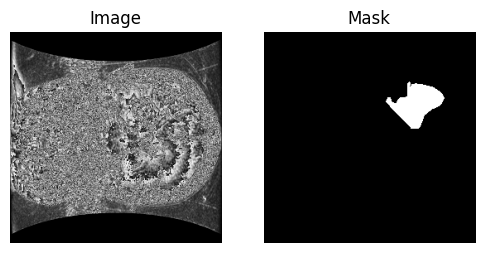

In [34]:
imgs, masks = next(iter(train_ds))
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(imgs[0].numpy().squeeze(), cmap="gray"); plt.title("Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(masks[0].numpy().squeeze(), cmap="gray"); plt.title("Mask"); plt.axis("off")
plt.show()


In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 256  # or 512 if your GPU allows

# ----- Metrics / losses -----
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def iou_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_pred_bin = tf.cast(y_pred_f > 0.5, tf.float32)
    inter = tf.reduce_sum(y_true_f * y_pred_bin)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_bin) - inter
    return (inter + smooth) / (union + smooth)

# ----- U-Net blocks -----
def conv_block(x, filters, dropout_rate=0.0):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    return x

def encoder_block(x, filters, dropout_rate=0.0):
    c = conv_block(x, filters, dropout_rate)
    p = layers.MaxPool2D(2)(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder (with some dropout)
    s1, p1 = encoder_block(inputs, 64,  dropout_rate=0.1)  # 256 -> 128
    s2, p2 = encoder_block(p1,     128, dropout_rate=0.1)  # 128 -> 64
    s3, p3 = encoder_block(p2,     256, dropout_rate=0.2)  # 64  -> 32
    s4, p4 = encoder_block(p3,     512, dropout_rate=0.3)  # 32  -> 16

    # Bottleneck
    b1 = conv_block(p4, 1024, dropout_rate=0.4)

    # Decoder
    d1 = decoder_block(b1, s4, 512)  # 16 -> 32
    d2 = decoder_block(d1, s3, 256)  # 32 -> 64
    d3 = decoder_block(d2, s2, 128)  # 64 -> 128
    d4 = decoder_block(d3, s1, 64)   # 128 -> 256

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)

    model = models.Model(inputs, outputs, name="UNet")
    return model

unet = build_unet()

unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # you can also try 5e-5
    loss=lambda y_true, y_pred: (
        tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    ),
    metrics=[dice_coefficient, iou_coefficient, "accuracy"],
)

unet.summary()


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        576 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,864 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ activation_19[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,728 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,456 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ activation_21[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ dropout_1[0][0] 

 Total params: 31,048,257 (118.44 MB)

 Trainable params: 31,036,481 (118.39 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [36]:
EPOCHS = 30  # train longer than 10

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_dice_coefficient",
        mode="max",
        patience=8,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_dice_coefficient",
        mode="max",
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_unet_figshare.keras",
        monitor="val_dice_coefficient",
        mode="max",
        save_best_only=True
    ),
]

history = unet.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8070 - dice_coefficient: 0.0413 - iou_coefficient: 0.0093 - loss: 1.3985

/usr/local/lib/python3.12/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: (
        tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    ),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


307/307 ━━━━━━━━━━━━━━━━━━━━ 188s 546ms/step - accuracy: 0.8074 - dice_coefficient: 0.0413 - iou_coefficient: 0.0093 - loss: 1.3979 - val_accuracy: 0.9886 - val_dice_coefficient: 0.0236 - val_iou_coefficient: 2.2136e-10 - val_loss: 1.1472 - learning_rate: 1.0000e-04
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 151s 492ms/step - accuracy: 0.9664 - dice_coefficient: 0.0860 - iou_coefficient: 0.0969 - loss: 1.0647 - val_accuracy: 0.9886 - val_dice_coefficient: 0.0177 - val_iou_coefficient: 2.2121e-10 - val_loss: 1.0730 - learning_rate: 1.0000e-04
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 151s 493ms/step - accuracy: 0.9650 - dice_coefficient: 0.1638 - iou_coefficient: 0.1906 - loss: 0.9532 - val_accuracy: 0.9875 - val_dice_coefficient: 0.0346 - val_iou_coefficient: 0.0329 - val_loss: 1.0367 - learning_rate: 1.0000e-04
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 152s 494ms/step - accuracy: 0.9723 - dice_coefficient: 0.2438 - iou_coefficient: 0.2445 - loss: 0.8475 - val_accuracy: 0.9880 - val_dice_coef

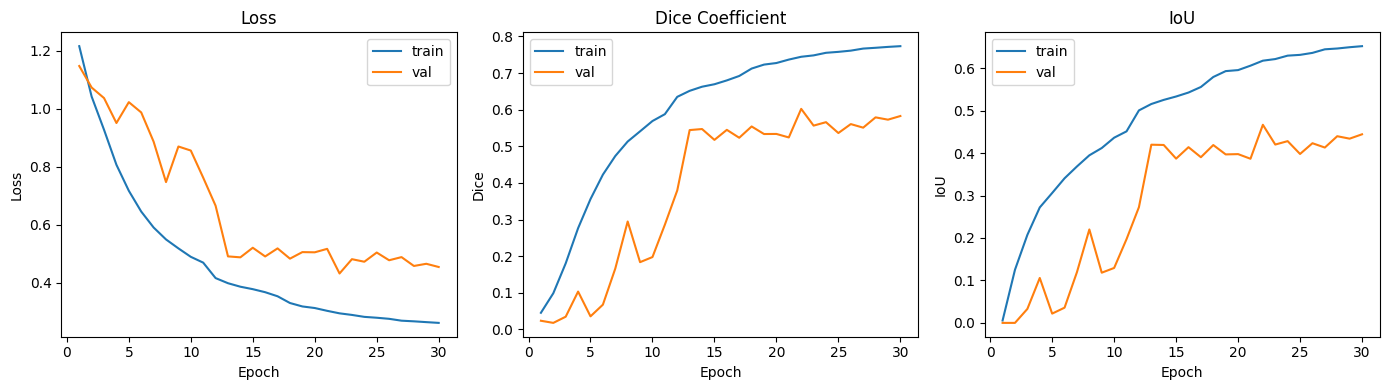

In [37]:
def plot_history(history):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.plot(epochs, hist["loss"], label="train")
    plt.plot(epochs, hist["val_loss"], label="val")
    plt.title("Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs, hist["dice_coefficient"], label="train")
    plt.plot(epochs, hist["val_dice_coefficient"], label="val")
    plt.title("Dice Coefficient")
    plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(epochs, hist["iou_coefficient"], label="train")
    plt.plot(epochs, hist["val_iou_coefficient"], label="val")
    plt.title("IoU")
    plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


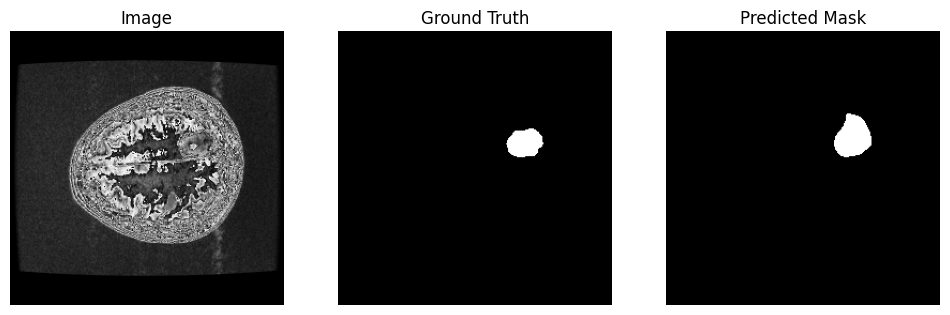

In [38]:
imgs, masks = next(iter(val_ds))
preds = model.predict(imgs)

i = 0  # index in batch
img  = imgs[i].numpy().squeeze()
mask = masks[i].numpy().squeeze()
pred = preds[i].squeeze()

pred_bin = (pred > 0.5).astype("float32")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap="gray"); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Ground Truth"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(pred_bin, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
plt.show()
